# Determining Correlations Between MA High Schools and Universities

### Summary
In the education industry, high schools prep students for the next chapter in his/her life. These skills are measured through SAT scores. Using student data from high schools in Massachusettes and recorded universities, how well prepared are high school students in Massachuesettes for universities in United States. Furthermore, based on enrollment, does a correlation exist with SAT scores? Lastly, is Massachuesettes high school's progress and performance index perform a good indicator based on student's SAT vs university acceptance on averages SAT scores?


In [57]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


#Import the first dataset (Massachusetts high school)
mshs=pd.read_csv('../data/external/MA_Public_Schools_2017.csv')

#Import the second dataset (University data)
univ=pd.read_json('../data/external/schoolInfo.json')

### Cleaning up datasets
The goal in mind requires few columns. After dropping unrelated columns, I remove the empty values on highly used data.

Massachusettes Data Set:
1. Drop all columns not related to SAT scores, schoool name, school location, school type (Private/Public), and PPI. These are the columns we desire to see correlation with university data
2. Since we only desire high schools, we view rows with 12th grade enrollment. Then drop this column. We do the same for SAT scores
3. Lastly, we remove rows with empty values in PPI scores

In [58]:
#Cleaning up MA high school data

#------------Dropping Columns------------
#Drop columns regarding MCAS scores
mshsFirst=mshs.iloc[:,0:31].copy()

mshsSecond=mshs.iloc[:,93:97].copy()

mshsLast=mshs.iloc[:,293:302].copy()

#also drop all demographics of students.
mshsdemo=mshs.iloc[:,51:53].copy()


#merge the tables
mshsFinal=mshsFirst.join(mshsdemo, how='outer')
mshsFinal=mshsFinal.join(mshsSecond, how='outer')
mshsFinal=mshsFinal.join(mshsLast, how='outer')

#Dropping...
#Contact name: column 5--- not irrelevant in detecting acceptance to universities
#Address 1 & 2: column 6,7---also not irrelevant. Can generalize by town.
#Phone and Fax:col 10,11---also not irrelevant

mshsFinal=mshsFinal.drop(columns=['School Code','Function','Contact Name','Address 1','Address 2','Phone','Fax','Grade','PK_Enrollment','K_Enrollment', '1_Enrollment',
                                  '2_Enrollment','3_Enrollment','4_Enrollment','5_Enrollment','6_Enrollment',
                                  '7_Enrollment', '8_Enrollment','9_Enrollment','10_Enrollment','11_Enrollment','Accountability and Assistance Level',
                                  'Accountability and Assistance Description','District_Accountability and Assistance Level',
                                  'District_Accountability and Assistance Description','Progress and Performance Index (PPI) - High Needs Students',
                                  'District_Progress and Performance Index (PPI) - High Needs Students','District Name','District Code',
                                 'SP_Enrollment','School Type'])


##------------Remove all non high schools or nonenrollment of seniors#------------
mshsFinal=mshsFinal[mshsFinal['12_Enrollment'] > 0]

#drop the column
mshsFinal=mshsFinal.drop(columns=['12_Enrollment'])

##------------Remove all rows without SAT data and district performance progress------------
mshsFinal=mshsFinal.dropna(subset=['School Accountability Percentile (1-99)'])

#Remove all rows without average SAT reading and SAT Math
mshsFinal=mshsFinal[mshsFinal['Average SAT_Reading']>0]
mshsFinal=mshsFinal[mshsFinal['Average SAT_Math']>0]


#Output MA Public School data....
#mshsFinal

#Cleaning up university data

#----------Dropping columns----------
#aliasNames=not relevant to viewing patterns between high school acceptance based on SAT data and demographics
#businessRepScore=most entries are NaN
#sortname=not relevant
#primaryphoto=not relevant
#primary photothumb=not relevant
#rankingdisplayname=not relevant
#rankingNoteCharacter=not relevant
#rankingNoteText=not relevant
#sortname=not relevant
#urlname=not relevant
#xwalkId=not relevant
#act-avg=not relevant
#all student demographic is not related.
#nonresponder and text=not relevant

univ=univ.drop(columns=['primaryKey','act-avg','aliasNames','businessRepScore','sortName',
                        'primaryPhoto','primaryPhotoThumb','rankingType','rankingMaxPossibleScore',
                        'rankingDisplayName','rankingNoteText','rankingNoteCharacter','sortName',
                        'urlName','xwalkId','nonResponder','nonResponderText','rankingIsTied',
                        'rankingRankStatus','engineeringRepScore','isPublic','cost-after-aid', 
                        'hs-gpa-avg', 'overallRank','percent-receiving-aid', 'rankingDisplayRank', 
                        'rankingDisplayScore','rankingSortRank','tuition'])

#remove NaN entries in sat-avg
univ=univ.dropna(subset=['sat-avg'])

#Output university data
#univ

### Transforming Data


In [59]:
#----------Transforming High School Data----------
#Transform high school public to boolean
#The data on school type is public OR charter school.
#charter schools seen as public from federal education department
mshsFinal['Institutional Control']=True

#Change town to city column name
mshsFinal.rename(columns={'Town':'City'},inplace=True)

#Change TOTAL Enrollment to Enrollment
mshsFinal.rename(columns={'TOTAL_Enrollment':'Enrollment'},inplace=True)

#Add column categorizing high schools vs universities (will help with merge)
mshsFinal.loc[:,'schoolType']=pd.Series('high-school', index=mshsFinal.index, dtype="category")

#Adding column and calculating average SAT scores
mshsFinal.loc[:,'sat-avg']=mshsFinal['Average SAT_Reading']+mshsFinal['Average SAT_Math']

#Change to categories for proper join
mshsFinal['schoolType']=mshsFinal['schoolType'].astype("category")
mshsFinal['School Name']=mshsFinal['School Name'].astype("category")

#Rank high schools in MA based on avg SAT scores
mshsFinal=mshsFinal.sort_values(['sat-avg'], ascending=False)
#reset index to create incremental ranking
mshsFinal=mshsFinal.reset_index()

#Start ranking at 1
mshsFinal['ranking']=mshsFinal.index+1


In [60]:
#----------Transforming University Data----------
#Change column for university name, city, zip, enrollment, and private/public institution for merge
univ.rename(columns={'displayName':'School Name', 'city':'City','zip':'Zip', 
                     'state':'State','enrollment':'Enrollment',
                     'institutionalControl':'Institutional Control'}, inplace=True)

#alter column to match column of other dataset
univ['schoolType']=univ['schoolType'].astype("category")
univ['School Name']=univ['School Name'].astype("category")



In [61]:
#----------Merge datasets----------
result=pd.concat([mshsFinal,univ],axis=0,sort=False )

#----------------Randomize data----------------
result=result.sample(frac=1)

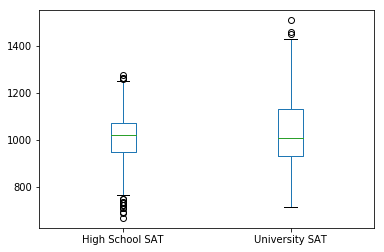

In [62]:
##----------------Plot the different average SAT scores of high schools in MA vs Universities----------------
#Plot average SAT scores 1 line is high school and 1 line is university
#export the sat-avg and School Type
SATforType=result[['schoolType','sat-avg']].copy()

#Separate high school and university SAT averages
SATforHS=SATforType.loc[SATforType['schoolType'] == 'high-school']
SATforU=SATforType.loc[SATforType['schoolType'] == 'national-universities']

#Create new Dataframe as High School and University average SAT for easy plotting
SATforType=pd.DataFrame(data={'High School SAT':SATforHS['sat-avg'], 'University SAT':SATforU['sat-avg']})

SATforType.plot.box()

#The results show the mean and the box shows 25-75% of the SAT average scores. 
#Comparing the high schools in MA and ranked universities, one can see the top SAT scores 
#for MA lacks quite a bit. Furthermore,

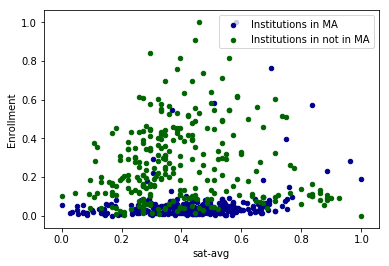

In [63]:
#----------------Viewing number of enrollment vs SAT scores----------------
EnrollvsSAT=result[['sat-avg','Enrollment','State']].copy()

#Sepearate by MA and the rest of the states
MaSAT=EnrollvsSAT.loc[EnrollvsSAT['State'] == 'MA']
OtherSAT=EnrollvsSAT.loc[EnrollvsSAT['State'] != 'MA']

#Drop state column for easier normalization
MaSAT=MaSAT.drop(columns=['State'])
OtherSAT=OtherSAT.drop(columns=['State'])

#Normalize this for better values
#Used this source for understanding normalizing(https://stackoverflow.com/questions/12525722/normalize-data-in-pandas )
MaSAT=(MaSAT - MaSAT.min()) / (MaSAT.max() - MaSAT.min())
OtherSAT=(OtherSAT - OtherSAT.min()) / (OtherSAT.max() - OtherSAT.min())

#Plot the separate states
ax = MaSAT.plot.scatter(x='sat-avg', y='Enrollment', color='DarkBlue', label='Institutions in MA')
OtherSAT.plot.scatter(x='sat-avg', y='Enrollment', color='DarkGreen', label='Institutions in not in MA', ax=ax)


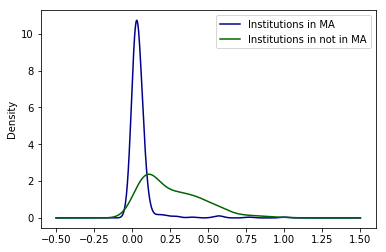

In [64]:
#----------------Viewing number of enrollment vs SAT scores----------------
EnrollvsSAT=result[['sat-avg','Enrollment','State']].copy()

#Sepearate by MA and the rest of the states
MaSAT=EnrollvsSAT.loc[EnrollvsSAT['State'] == 'MA']
OtherSAT=EnrollvsSAT.loc[EnrollvsSAT['State'] != 'MA']

#Drop state column for easier normalization
MaSAT=MaSAT.drop(columns=['State'])
OtherSAT=OtherSAT.drop(columns=['State'])

#Normalize this for better values
#Used this source for understanding normalizing(https://stackoverflow.com/questions/12525722/normalize-data-in-pandas )
MaSAT=(MaSAT - MaSAT.min()) / (MaSAT.max() - MaSAT.min())
OtherSAT=(OtherSAT - OtherSAT.min()) / (OtherSAT.max() - OtherSAT.min())

#Plot the separate states
ax = MaSAT.plot.kde(x='sat-avg', y='Enrollment', color='DarkBlue', label='Institutions in MA')
OtherSAT.plot.kde(x='sat-avg', y='Enrollment', color='DarkGreen', label='Institutions in not in MA', ax=ax)


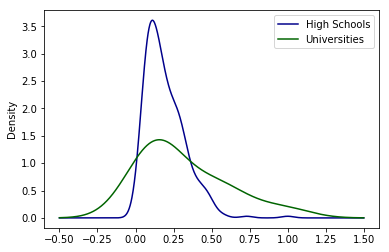

In [65]:
#----------------Viewing number of SAT scores and Enrollment of MA universities vs high school----------------
SAT=result[['sat-avg','Enrollment','State','schoolType']].copy()

#Sepearate by MA
SAT=SAT.loc[SAT['State'] == 'MA']

HSSAT=SAT.loc[SAT['schoolType'] == 'high-school'].copy()
USAT=SAT.loc[SAT['schoolType'] == 'national-universities'].copy()

#Drop state column for easier normalization
HSSAT=HSSAT.drop(columns=['State'])
USAT=USAT.drop(columns=['State'])

HSSAT=HSSAT.drop(columns=['schoolType'])
USAT=USAT.drop(columns=['schoolType'])

#Normalize this for better values
#Used this source for understanding normalizing(https://stackoverflow.com/questions/12525722/normalize-data-in-pandas )
HSSAT=(HSSAT - HSSAT.min()) / (HSSAT.max() - HSSAT.min())
USAT=(USAT - USAT.min()) / (USAT.max() - USAT.min())

#Plot the separate states
ax = HSSAT.plot.kde(x='sat-avg',y='Enrollment', color='DarkBlue', label='High Schools')
USAT.plot.kde(x='sat-avg',y='Enrollment', color='DarkGreen', label='Universities', ax=ax)

In [66]:
result.columns

Index(['index', 'School Name', 'City', 'State', 'Zip', 'Enrollment',
       'Average Class Size', 'Number of Students', 'SAT_Tests Taken',
       'Average SAT_Reading', 'Average SAT_Writing', 'Average SAT_Math',
       'School Accountability Percentile (1-99)',
       'Progress and Performance Index (PPI) - All Students',
       'District_Progress and Performance Index (PPI) - All Students',
       'Institutional Control', 'schoolType', 'sat-avg', 'ranking',
       'acceptance-rate', 'region'],
      dtype='object')